# SML 301
## Session 5: Dimension Reduction

* Gaussian Discrimant
* Linear Discriminant Analysis
* Quadratic Discriminant Analysis

In [ ]:
#%pip install ISLP

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ISLP import load_data, confusion_table
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA,
                                           QuadraticDiscriminantAnalysis as QDA)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score,
                             confusion_matrix)
from sklearn.preprocessing import OneHotEncoder

# Gaussian Discriminant Demo

In [2]:
# Gaussian discriminant analysis in 2d
# Author: Duane Rich, heavily modified by Kevin Murphy
# Based on matlab code by Kevin Murphy
# https://github.com/probml/pmtk3/blob/master/demos/discrimAnalysisDboundariesDemo.m

def mvn2d(x, y, u, sigma):
    xx, yy = np.meshgrid(x, y)
    xy = np.c_[xx.ravel(), yy.ravel()]
    sigma_inv = np.linalg.inv(sigma)
    z = np.dot((xy - u), sigma_inv)
    z = np.sum(z * (xy - u), axis=1)
    z = np.exp(-0.5 * z)
    z = z / (2 * np.pi * np.linalg.det(sigma) ** 0.5)
    return z.reshape(xx.shape)


# Each model specifies the means and covariances.
# If the covariances are equal across classes, dboundarioes
# will be linear even if we use QDA


def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)


Sigma1 = np.array([[4, 1], [1, 2]])
Sigma2 = np.array([[2, 0], [0, 1]])
Sigma3 = np.eye(2)

mus = [[0, 0], [0, 4], [4, 4]]
sigmas = [Sigma1, Sigma2, Sigma3]
# model = ([[0, 0], [0, 4], [4, 4]], [Sigma1, Sigma2, Sigma3])

ngrid = 200
n_samples = 30  # 300  # number of each class samples
model_names = ("LDA", "QDA")
np.random.seed(0)


def make_data(mu, sigma):
    # generate random points
    x = []  # store sample points
    labels = []  # store class labels
    nclasses = len(mu)  # means
    for i in range(nclasses):
        x.append(np.random.multivariate_normal(mu[i], sigma[i], n_samples))
        labels.append([i] * n_samples)
    return x, labels


def make_grid(x):
    points = np.vstack(x)
    x_min, y_min = np.min(points, axis=0)
    x_max, y_max = np.max(points, axis=0)
    x_range = np.linspace(x_min - 1, x_max + 1, ngrid)
    y_range = np.linspace(y_min - 1, y_max + 1, ngrid)
    xx, yy = np.meshgrid(x_range, y_range)
    return xx, yy, x_range, y_range


def plot_dboundaries(xx, yy, z, z_p):
    plt.pcolormesh(xx, yy, z, alpha=0.1)
    plt.jet()
    nclasses = z_p.shape[1]
    for j in range(nclasses):
        plt.contour(xx, yy, z_p[:, j].reshape(ngrid, ngrid), [0.5], lw=3, colors="k")


def plot_points(x):
    c = "bgr"
    m = "xos"
    for i, point in enumerate(x):
        N = point.shape[0]
        nplot = min(N, 30)
        plt.plot(point[:nplot, 0], point[:nplot, 1], c[i] + m[i])


def plot_contours(xx, yy, x_range, y_range, u, sigma):
    nclasses = len(u)
    c = "bgr"
    m = "xos"
    for i in range(nclasses):
        prob = mvn2d(x_range, y_range, u[i], sigma[i])
        cs = plt.contour(xx, yy, prob, colors=c[i])


def make_one_hot(yhat):
    yy = yhat.reshape(-1, 1)  # make 2d
    enc = OneHotEncoder()
    Y = enc.fit_transform(yy)
    return Y

def estimate_mvns(X, Y):
    classes = np.unique(Y)
    mus = []
    sigmas = []
    for c in classes:
        ndx = Y == c
        Xc = X[ndx]
        mu_c = np.mean(Xc, axis=0)
        Sigma_c = np.cov(Xc, rowvar=False)
        mus.append(mu_c)
        sigmas.append(Sigma_c)
    return mus, sigmas

def estimate_mvn_tied(X, Y):
    classes = np.unique(Y)
    nclasses = len(classes)
    Sigma = np.cov(X, rowvar=False)
    sigmas = [Sigma] * nclasses
    mus = []
    for c in classes:
        ndx = Y == c
        Xc = X[ndx]
        mu_c = np.mean(Xc, axis=0)
        mus.append(mu_c)
    return mus, sigmas

def fit_and_plot(clf, name, mus, sigmas):
    clf.fit(X, Y)
    z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(ngrid, ngrid)
    z_p = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    yhat = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Yhat = make_one_hot(yhat)

    plt.figure()
    plot_dboundaries(xx, yy, z, z_p)
    # plot_dboundaries(xx, yy, z, Yhat)
    plot_points(x)
    plot_contours(xx, yy, x_range, y_range, mus, sigmas)
    plt.title(name)
    plt.axis("square")
    plt.tight_layout()
    #savefig("gda_2d_{}.pdf".format(name))
    plt.show()

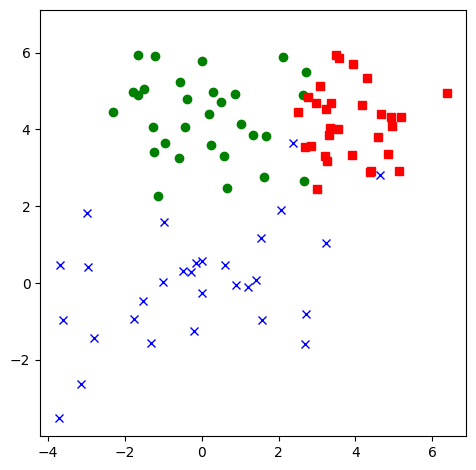

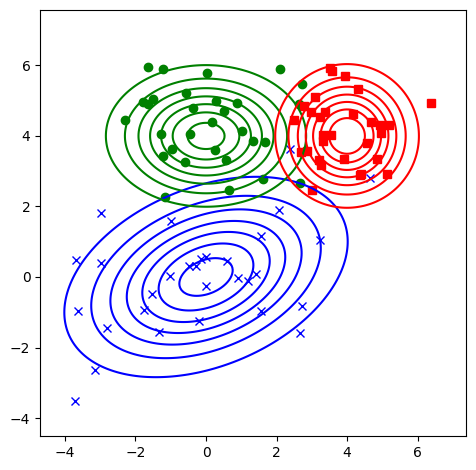

In [3]:
x, labels = make_data(mus, sigmas)
xx, yy, x_range, y_range = make_grid(x)
X = np.vstack(x)
Y = np.hstack(labels)

plt.figure()
plot_points(x)
plt.axis("square")
plt.tight_layout()
#savefig("gda_2d_data.pdf")
plt.show()

plt.figure()
plot_points(x)
plot_contours(xx, yy, x_range, y_range, mus, sigmas)
plt.axis("square")
plt.tight_layout()
#savefig("gda_2d_contours.pdf")
plt.show()

## Linear Discriminant Analysis

<positron-console-cell-4>:66: UserWarning: The following kwargs were not used by contour: 'lw'


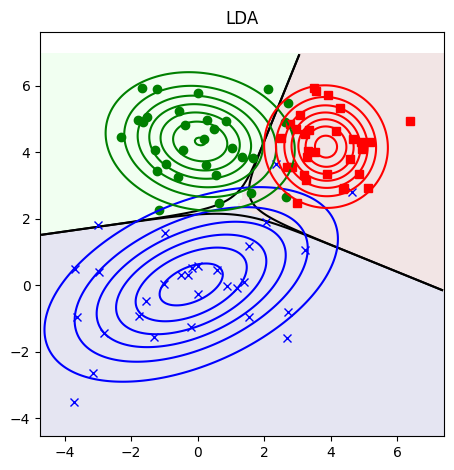

In [4]:
mus_est, sigmas_est = estimate_mvns(X, Y)
fit_and_plot(LDA(), "LDA", mus_est, sigmas_est)

<positron-console-cell-5>:66: UserWarning: The following kwargs were not used by contour: 'lw'


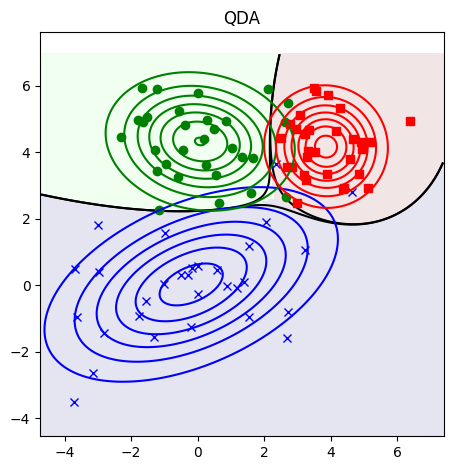

In [5]:
fit_and_plot(QDA(), "QDA", mus_est, sigmas_est)

# Classification Workflow

In [6]:
# data set: stock market (from ISLP)
smarket_df = load_data("Smarket")
historical_data = smarket_df.loc[(smarket_df.Year < 2005)]
future_data = smarket_df.loc[(smarket_df.Year == 2005)]
X_train = historical_data[['Lag1']]
X_test = future_data[['Lag1']]
y_train = historical_data['Direction']
y_test = future_data['Direction']
smarket_df.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


## Logistic Regression

In [7]:
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)
y_pred = log_reg_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))

[[ 20  91]
 [ 25 116]]
Accuracy:  0.5396825396825397


## Linear Discriminant Analysis

In [8]:
LDA_model = LDA(store_covariance=True)
LDA_model.fit(X_train, y_train)
y_pred = LDA_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))

[[ 20  91]
 [ 25 116]]
Accuracy:  0.5396825396825397


## Quadratic Discriminant Analysis

In [9]:
QDA_model = QDA(store_covariance=True)
QDA_model.fit(X_train, y_train)
y_pred = QDA_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))

[[ 25  86]
 [ 27 114]]
Accuracy:  0.5515873015873016
